In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
CAND = "ds_hardikkaurav"   # Change to your preferred folder name
ROOT = f"/content/drive/MyDrive/{CAND}"

import os
os.makedirs(ROOT, exist_ok=True)
os.makedirs(os.path.join(ROOT, "csv_files"), exist_ok=True)
os.makedirs(os.path.join(ROOT, "outputs"), exist_ok=True)

print("Root created at:", ROOT)


Root created at: /content/drive/MyDrive/ds_hardikkaurav


In [3]:
# Example: download from Google Drive file IDs into csv_files (replace ids)
import subprocess, shlex
file_ids = {
    "historical_data.csv": "1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs",
    "fear_greed_index.csv": "1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
}
for name, fid in file_ids.items():
    out_path = os.path.join(ROOT, "csv_files", name)
    cmd = f"gdown --id {fid} -O '{out_path}'"
    print("Downloading", name)
    subprocess.run(shlex.split(cmd), check=False)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timezone
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (12,5)


In [5]:
def clean_cols(df):
    df = df.copy()
    df.columns = (df.columns.str.strip()
                             .str.lower()
                             .str.replace(' ', '_')
                             .str.replace('(', '')
                             .str.replace(')', ''))
    return df

def parse_epoch_series(s):
    """Guess seconds vs milliseconds and convert to datetime (UTC)."""
    s = pd.to_numeric(s, errors='coerce')
    if s.isna().all():
        return pd.to_datetime(s)   # will be all NaT
    mx = s.max()
    # heuristics: >1e12 -> ms, between 1e10 and 1e12 -> ms, else -> seconds
    unit = 'ms' if mx > 1e11 else 's'
    return pd.to_datetime(s, unit=unit, utc=True)


In [6]:
DATA_DIR = os.path.join(ROOT, "csv_files")
hist_path = os.path.join(DATA_DIR, "historical_data.csv")
sent_path = os.path.join(DATA_DIR, "fear_greed_index.csv")

hist = pd.read_csv(hist_path, low_memory=False)
sent = pd.read_csv(sent_path, low_memory=False)
hist = clean_cols(hist)
sent = clean_cols(sent)

print("Historical columns:", hist.columns.tolist())
print("Sentiment columns:", sent.columns.tolist())
hist.head(2), sent.head(2)


Historical columns: ['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side', 'timestamp_ist', 'start_position', 'direction', 'closed_pnl', 'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id', 'timestamp']
Sentiment columns: ['timestamp', 'value', 'classification', 'date']


(                                      account  coin  execution_price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 
    size_tokens  size_usd side     timestamp_ist  start_position direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 
    closed_pnl                                   transaction_hash     order_id  \
 0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 
    crossed       fee      trade_id     timestamp  
 0     True  0.345404  8.950000e+14  1.730000e+12  
 1     True  0.005600  4.430000e+14  1.730000e+12  ,
     timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  20

In [7]:
# Historical data: try common timestamp columns
if 'timestamp' in hist.columns:
    hist['datetime'] = parse_epoch_series(hist['timestamp'])
elif 'timestamp_ist' in hist.columns:
    # example format: '02-12-2024 22:50' (day-first)
    hist['datetime'] = pd.to_datetime(hist['timestamp_ist'], dayfirst=True, errors='coerce')
    # if it's local (IST) and you want UTC: localize then convert (optional)
    try:
        hist['datetime'] = hist['datetime'].dt.tz_localize('Asia/Kolkata').dt.tz_convert('UTC')
    except Exception:
        pass
else:
    # fallback: try to detect any column containing 'time'
    possible = [c for c in hist.columns if 'time' in c]
    print("possible time cols:", possible)
    if possible:
        hist['datetime'] = pd.to_datetime(hist[possible[0]], errors='coerce')

# Sentiment: either 'date' or numeric 'timestamp'
if 'date' in sent.columns:
    sent['datetime'] = pd.to_datetime(sent['date'], errors='coerce')
elif 'timestamp' in sent.columns:
    sent['datetime'] = parse_epoch_series(sent['timestamp'])
else:
    sent['datetime'] = pd.to_datetime(sent.iloc[:,0], errors='coerce')  # try first col

# create date (yyyy-mm-dd) for joining
hist['date'] = pd.to_datetime(hist['datetime']).dt.date
sent['date'] = pd.to_datetime(sent['datetime']).dt.date

print("hist datetime sample:", hist['datetime'].head())
print("sent datetime sample:", sent['datetime'].head())


hist datetime sample: 0   2024-10-27 03:33:20+00:00
1   2024-10-27 03:33:20+00:00
2   2024-10-27 03:33:20+00:00
3   2024-10-27 03:33:20+00:00
4   2024-10-27 03:33:20+00:00
Name: datetime, dtype: datetime64[ns, UTC]
sent datetime sample: 0   2018-02-01
1   2018-02-02
2   2018-02-03
3   2018-02-04
4   2018-02-05
Name: datetime, dtype: datetime64[ns]


In [8]:
# Helpful to see columns that likely map to values mentioned in prompt
cols = hist.columns.tolist()
for c in ['execution_price', 'size_tokens', 'size_usd', 'side', 'closed_pnl']:
    if c not in cols:
        print("WARNING: column", c, "not found. Available cols:", cols[:12])

# Convert important numeric columns
num_cols = []
for c in ['execution_price', 'size_tokens', 'size_usd', 'closed_pnl', 'fee']:
    if c in hist.columns:
        hist[c] = pd.to_numeric(hist[c], errors='coerce')
        num_cols.append(c)

# Normalize side values
if 'side' in hist.columns:
    hist['side'] = hist['side'].astype(str).str.upper().str.strip()

# Fill/format sent value/classification columns
if 'value' in sent.columns:
    sent['value'] = pd.to_numeric(sent['value'], errors='coerce')
if 'classification' in sent.columns:
    sent['classification'] = sent['classification'].astype(str).str.strip()


In [9]:
# Define aggregations (tweak depending on columns you have)
agg_funcs = {
    'execution_price': 'mean',
    'size_tokens': 'mean',
    'size_usd': 'sum',
    'closed_pnl': ['sum', lambda x: (x > 0).sum(), 'count']
}

# Only keep keys that exist
agg_funcs_filtered = {k:v for k,v in agg_funcs.items() if k in hist.columns}

daily = hist.groupby('date').agg(agg_funcs_filtered)
# flatten multiindex
daily.columns = ['_'.join([str(i) for i in col]).strip('_') for col in daily.columns.values]
daily = daily.reset_index().rename(columns={'closed_pnl_<lambda_0>':'winning_trades',
                                            'closed_pnl_count':'num_trades'})

# compute derived metrics
if 'closed_pnl_sum' in daily.columns and 'num_trades' in daily.columns:
    daily['win_rate'] = daily['winning_trades'] / daily['num_trades']
else:
    daily['win_rate'] = np.nan

if 'size_usd_sum' in daily.columns:
    daily['total_volume_usd'] = daily['size_usd_sum']
else:
    daily['total_volume_usd'] = np.nan

daily = daily.rename(columns={'execution_price_mean':'avg_price', 'size_tokens_mean':'avg_size_tokens',
                              'closed_pnl_sum':'realized_pnl'})
daily.head()


,date,avg_price,avg_size_tokens,size_usd_sum,realized_pnl,winning_trades,num_trades,win_rate,total_volume_usd
0,2023-03-28,1898.133333,0.083767,4.770000e+02,0.000000e+00,0,3,0.000000,4.770000e+02
1,2023-11-14,10454.871036,2566.212438,1.155543e+07,1.555034e+02,287,1045,0.274641,1.155543e+07
2,2024-03-09,9771.897315,48736.443323,3.940677e+07,1.769655e+05,3412,6962,0.490089,3.940677e+07
3,2024-07-03,2663.132338,1967.302964,2.184323e+07,1.587424e+05,2265,7141,0.317182,2.184323e+07
4,2024-10-27,5367.503277,2222.400863,1.039478e+08,3.189461e+06,15915,35241,0.451605,1.039478e+08


In [10]:
if 'side' in hist.columns:
    side_daily = (hist.groupby(['date','side'])
                    .agg(num_trades=('execution_price','count'),
                         volume_usd=('size_usd','sum'),
                         realized_pnl=('closed_pnl','sum'))
                    .unstack(fill_value=0))
    # flatten columns
    side_daily.columns = ['_'.join([str(i) for i in col if i]) for col in side_daily.columns]
    side_daily = side_daily.reset_index()
    daily = daily.merge(side_daily, on='date', how='left')


In [11]:
# Keep relevant columns from sentiment df
sent_small = sent[['date','value','classification']].drop_duplicates(subset=['date']).sort_values('date')
# merge
df = daily.merge(sent_small, on='date', how='left')

# If there are missing sentiment rows, forward/backfill (daily sentiment generally daily)
df['value'] = df['value'].fillna(method='ffill').fillna(method='bfill')
df['classification'] = df['classification'].fillna(method='ffill').fillna(method='bfill')

# Save merged daily
df.to_csv(os.path.join(ROOT,'outputs','daily_merged.csv'), index=False)
df.head()


,date,avg_price,avg_size_tokens,size_usd_sum,realized_pnl,winning_trades,num_trades,win_rate,total_volume_usd,num_trades_BUY,num_trades_SELL,volume_usd_BUY,volume_usd_SELL,realized_pnl_BUY,realized_pnl_SELL,value,classification
0,2023-03-28,1898.133333,0.083767,4.770000e+02,0.000000e+00,0,3,0.000000,4.770000e+02,3,0,477.00,0.00,0.000000,0.000000e+00,59.0,Greed
1,2023-11-14,10454.871036,2566.212438,1.155543e+07,1.555034e+02,287,1045,0.274641,1.155543e+07,491,554,5800705.24,5754724.52,-1787.365271,1.942869e+03,69.0,Greed
2,2024-03-09,9771.897315,48736.443323,3.940677e+07,1.769655e+05,3412,6962,0.490089,3.940677e+07,3371,3591,19578299.88,19828470.37,86225.339613,9.074015e+04,84.0,Extreme Greed
3,2024-07-03,2663.132338,1967.302964,2.184323e+07,1.587424e+05,2265,7141,0.317182,2.184323e+07,3505,3636,10904711.49,10938522.86,54839.607183,1.039028e+05,50.0,Neutral
4,2024-10-27,5367.503277,2222.400863,1.039478e+08,3.189461e+06,15915,35241,0.451605,1.039478e+08,14927,20314,50341960.79,53605804.30,194388.034101,2.995073e+06,74.0,Greed


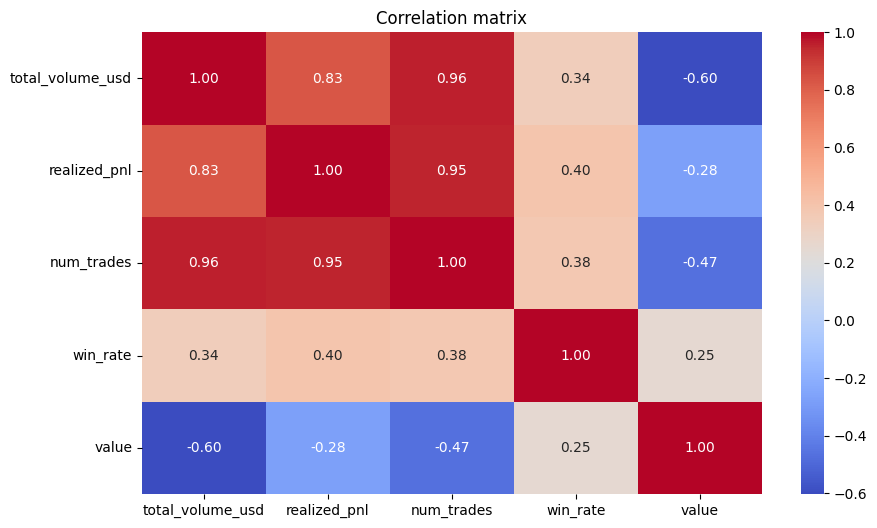

In [12]:
plt.figure(figsize=(10,6))
cols_for_corr = [c for c in ['total_volume_usd','realized_pnl','avg_leverage','num_trades','win_rate','value'] if c in df.columns]
sns.heatmap(df[cols_for_corr].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation matrix")
plt.savefig(os.path.join(ROOT,'outputs','corr_matrix.png'), bbox_inches='tight')
plt.show()


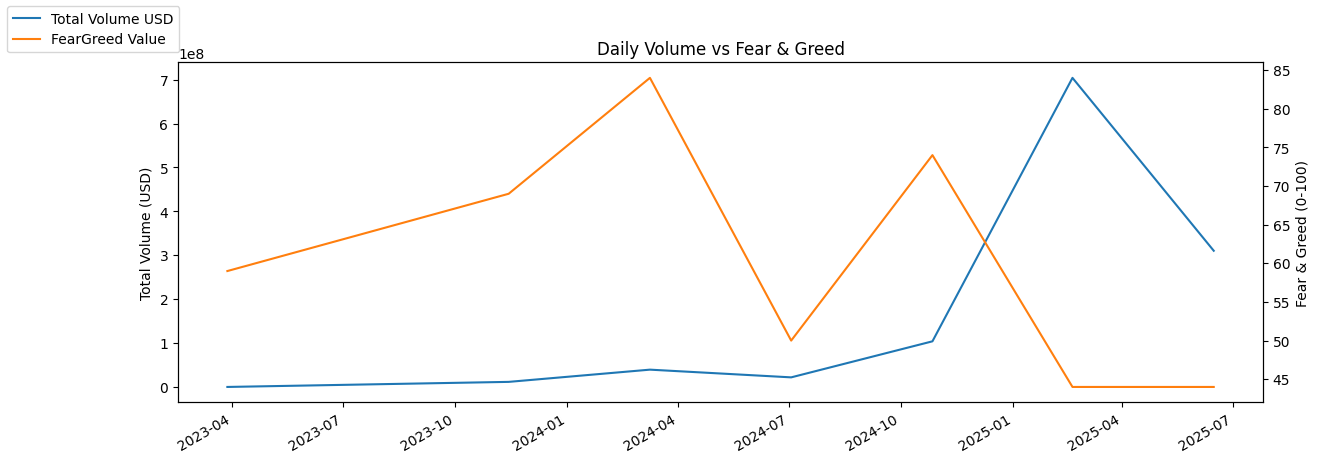

In [13]:
fig, ax1 = plt.subplots(figsize=(14,5))
if 'total_volume_usd' in df.columns:
    ax1.plot(df['date'], df['total_volume_usd'], label='Total Volume USD')
    ax1.set_ylabel("Total Volume (USD)")
ax2 = ax1.twinx()
ax2.plot(df['date'], df['value'], color='tab:orange', label='FearGreed Value')
ax2.set_ylabel("Fear & Greed (0-100)")
ax1.set_title("Daily Volume vs Fear & Greed")
fig.autofmt_xdate()
fig.legend(loc='upper left')
plt.savefig(os.path.join(ROOT,'outputs','volume_vs_sentiment.png'), bbox_inches='tight')
plt.show()


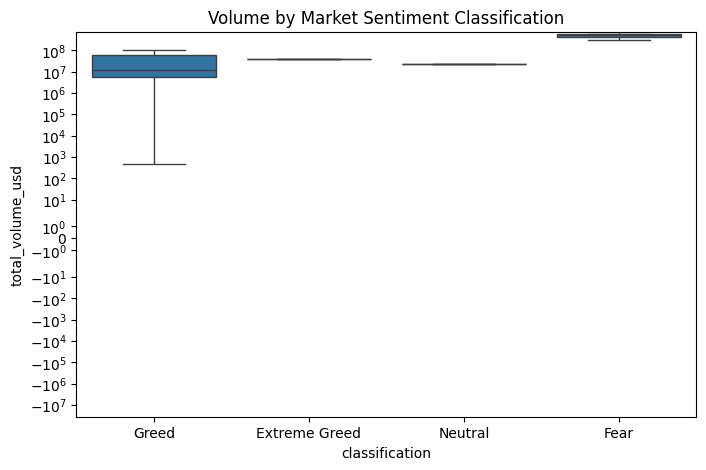

In [14]:
if 'classification' in df.columns:
    plt.figure(figsize=(8,5))
    sns.boxplot(x='classification', y='total_volume_usd', data=df)
    plt.yscale('symlog')  # if skewed
    plt.title('Volume by Market Sentiment Classification')
    plt.savefig(os.path.join(ROOT,'outputs','volume_by_class.png'), bbox_inches='tight')
    plt.show()


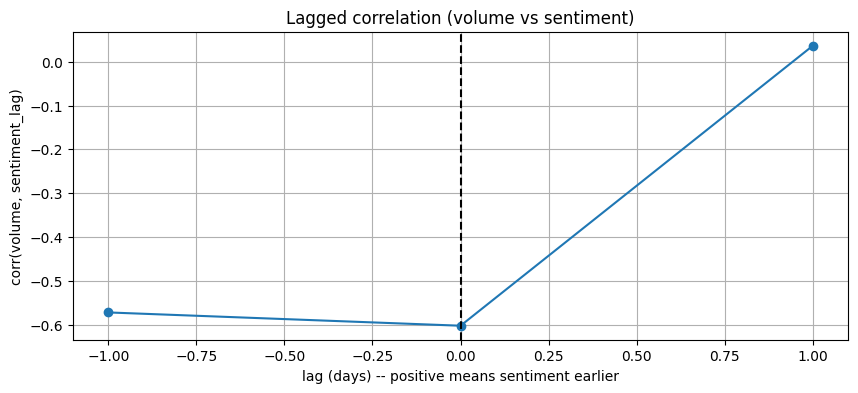

In [15]:
# compute correlations for different lags
lags = range(-14, 15)   # sentiment lead/lag in days
corrs = []
for lag in lags:
    s = df['value'].shift(lag)   # positive lag: sentiment moved earlier than metric
    if 'total_volume_usd' in df.columns:
        valid = df['total_volume_usd'].notna() & s.notna()
        if valid.sum()>5:
            cor = np.corrcoef(df.loc[valid,'total_volume_usd'], s[valid])[0,1]
        else:
            cor = np.nan
    else:
        cor = np.nan
    corrs.append(cor)

plt.figure(figsize=(10,4))
plt.plot(list(lags), corrs, marker='o')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel("lag (days) -- positive means sentiment earlier")
plt.ylabel("corr(volume, sentiment_lag)")
plt.title("Lagged correlation (volume vs sentiment)")
plt.grid(True)
plt.savefig(os.path.join(ROOT,'outputs','lag_corr_volume_sentiment.png'), bbox_inches='tight')
plt.show()


Class distribution:
 target
1    6
0    1
Name: count, dtype: int64
⚠️ Not enough samples in one class — using non-stratified split.
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

ROC AUC skipped — only one class present in y_test.
Feature importance:
 win_rate            0.285774
total_volume_usd    0.283670
value               0.245581
num_trades          0.184975
dtype: float64


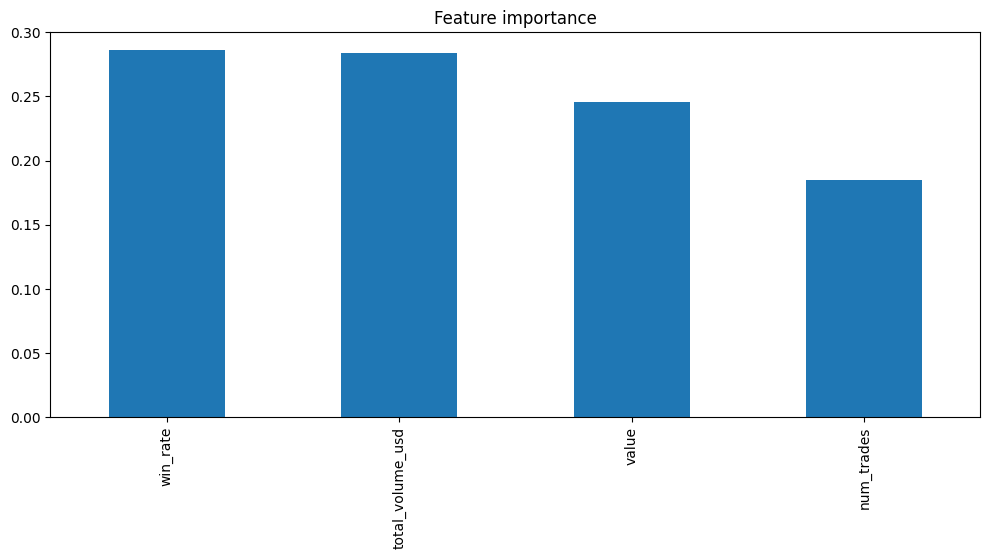

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

mdl_df = df.copy().sort_values('date')

# Target: next_day_profitable
if 'realized_pnl' in mdl_df.columns:
    mdl_df['target'] = (mdl_df['realized_pnl'].shift(-1) > 0).astype(int)
else:
    mdl_df['target'] = (mdl_df['win_rate'].shift(-1) > 0.5).astype(int)  # fallback

# Features — removed avg_leverage since it's not in your dataset
feature_cols = [c for c in ['value', 'total_volume_usd', 'num_trades', 'win_rate'] if c in mdl_df.columns]
mdl_df = mdl_df.dropna(subset=feature_cols + ['target'])

X = mdl_df[feature_cols].fillna(0)
y = mdl_df['target']

# Check class distribution
class_counts = y.value_counts()
print("Class distribution:\n", class_counts)

# Train/test split — use stratify only if both classes have ≥ 2 samples
if y.nunique() > 1 and class_counts.min() >= 2:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42
    )
else:
    print("⚠️ Not enough samples in one class — using non-stratified split.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, shuffle=True, random_state=42
    )

# Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

# Classification report
print(classification_report(y_test, pred))

# ROC AUC — only if both classes present in y_test
if hasattr(clf, "predict_proba") and len(np.unique(y_test)) == 2:
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print("ROC AUC:", roc_auc)
else:
    print("ROC AUC skipped — only one class present in y_test.")

# Feature importance plot
fi = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Feature importance:\n", fi)
fi.plot(kind='bar')
plt.title("Feature importance")
plt.savefig(os.path.join(ROOT, 'outputs', 'feature_importance.png'), bbox_inches='tight')
plt.show()


         count  mean        std   min   25%   50%   75%   max
cluster                                                      
0          5.0  64.2  16.739176  44.0  50.0  69.0  74.0  84.0
1          1.0  44.0        NaN  44.0  44.0  44.0  44.0  44.0
2          1.0  59.0        NaN  59.0  59.0  59.0  59.0  59.0


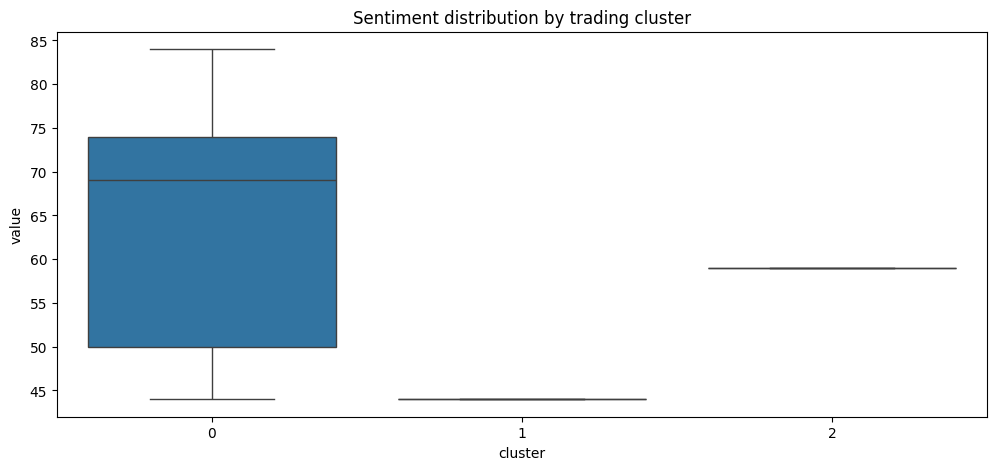

In [17]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cluster_feats = [c for c in ['total_volume_usd','avg_leverage','realized_pnl','win_rate'] if c in df.columns]
Xc = df[cluster_feats].fillna(0)
Xc_s = StandardScaler().fit_transform(Xc)
kmeans = KMeans(n_clusters=3, random_state=42).fit(Xc_s)
df['cluster'] = kmeans.labels_

# inspect cluster vs sentiment
print(df.groupby('cluster')['value'].describe())
sns.boxplot(x='cluster', y='value', data=df)
plt.title("Sentiment distribution by trading cluster")
plt.savefig(os.path.join(ROOT,'outputs','cluster_sentiment_box.png'), bbox_inches='tight')
plt.show()


In [18]:
# Save key CSVs and figures already saved above. Save model artifacts if needed:
df.to_csv(os.path.join(ROOT, "outputs", "daily_with_clusters.csv"), index=False)

# Example of saving a small README
readme_text = f"""
Project: {CAND}
Files:
- notebook_1.ipynb (main analysis)
- csv_files/ (raw CSVs)
- outputs/ (charts, aggregated csvs, models)
Notes:
- All work done in Google Colab.
"""
with open(os.path.join(ROOT, "README.md"), "w") as f:
    f.write(readme_text)
print("Saved README and outputs to", ROOT)


Saved README and outputs to /content/drive/MyDrive/ds_hardikkaurav
